In [1]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, create_react_agent
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
from typing import Literal, TypedDict, Annotated
import operator
import os
import json
from pydantic import BaseModel

print("All imports successful")

c:\Users\DELL\Desktop\Exercises\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All imports successful


In [2]:
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found!")

print("API key loaded")

API key loaded


In [3]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=openai_api_key
)

print(f"LLM initialized: {llm.model_name}")

LLM initialized: gpt-4o-mini


In [4]:
class HybridState(TypedDict):
    input: str
    plan: list[str]
    current_step: int
    results: Annotated[list[str], operator.add]
    draft: str
    critique: str
    reflection_iterations: int
    final_output: str

MAX_STEPS = 5
MAX_REFLECTIONS_HYBRID = 2

print("HybridState defined")
print(f"MAX_STEPS: {MAX_STEPS}")
print(f"MAX_REFLECTIONS_HYBRID: {MAX_REFLECTIONS_HYBRID}")

HybridState defined
MAX_STEPS: 5
MAX_REFLECTIONS_HYBRID: 2


In [5]:
def planner(state: HybridState) -> dict:
    prompt = f"Create a step-by-step plan for this task:\n\nTask: {state['input']}\n\nReturn a numbered list of concrete steps. Keep it simple (3-5 steps)."
    
    response = llm.invoke([HumanMessage(content=prompt)])
    lines = response.content.split('\n')
    steps = [line.strip() for line in lines if line.strip() and any(char.isdigit() for char in line[:3])]
    
    print("PLAN CREATED")
    for i, step in enumerate(steps, 1):
        print(f"{i}. {step}")
    print()
    
    return {"plan": steps, "current_step": 0, "results": []}

print("Planner node defined")

Planner node defined


In [6]:
def executor(state: HybridState) -> dict:
    if state["current_step"] >= len(state["plan"]):
        return {}
    
    current_step = state["plan"][state["current_step"]]
    
    print(f"Executing step {state['current_step'] + 1}: {current_step}")
    
    prompt = f"Execute this step: {current_step}\n\nPrevious results: {state.get('results', [])}"
    response = llm.invoke([HumanMessage(content=prompt)])
    
    result = f"Step {state['current_step'] + 1} result: {response.content}"
    print(f"Result: {result[:100]}...")
    print()
    
    return {
        "results": [result],
        "current_step": state["current_step"] + 1
    }

print("Executor node defined")

Executor node defined


In [7]:
def generator_hybrid(state: HybridState) -> dict:
    prompt = f"""Synthesize all step results into a cohesive draft:

Original task: {state['input']}

Execution results:
{chr(10).join(state['results'])}

Create a clear, comprehensive final draft that addresses the original task."""
    
    print("Synthesizing results into draft")
    response = llm.invoke([HumanMessage(content=prompt)])
    
    draft = response.content
    print(f"Initial draft created, length: {len(draft)} characters")
    
    return {"draft": draft}

print("Generator_hybrid node defined")

Generator_hybrid node defined


In [8]:
def critic_hybrid(state: HybridState) -> dict:
    prompt = f"""Evaluate this draft and provide constructive critique:

Original task: {state['input']}

Draft: {state['draft']}

What could be improved? Focus on clarity, completeness, and accuracy.
If excellent, say "APPROVED"."""
    
    print("Critiquing final draft")
    response = llm.invoke([HumanMessage(content=prompt)])
    critique = response.content
    
    print(f"Critique: {critique[:100]}...")
    print()
    
    return {
        "critique": critique,
        "reflection_iterations": state.get("reflection_iterations", 0) + 1
    }

print("Critic_hybrid node defined")

Critic_hybrid node defined


In [9]:
def refiner(state: HybridState) -> dict:
    prompt = f"""Improve this draft based on the critique:

Original task: {state['input']}

Current draft: {state['draft']}

Critique: {state['critique']}

Create an improved version."""
    
    print(f"Refining draft, reflection iteration {state.get('reflection_iterations', 0)}")
    response = llm.invoke([HumanMessage(content=prompt)])
    
    print("Draft refined")
    
    return {"draft": response.content}

print("Refiner node defined")

Refiner node defined


In [10]:
def hybrid_finalizer(state: HybridState) -> dict:
    print("Hybrid process complete")
    return {"final_output": state["draft"]}

print("Hybrid_finalizer node defined")

Hybrid_finalizer node defined


In [11]:
def should_continue_execution(state: HybridState) -> Literal["executor", "generator_hybrid"]:
    if state["current_step"] < len(state["plan"]):
        return "executor"
    return "generator_hybrid"

print("should_continue_execution routing function defined")

should_continue_execution routing function defined


In [13]:
def should_refine(state: HybridState) -> Literal["refiner", "hybrid_finalizer"]:
    if "APPROVED" in state.get("critique", "").upper():
        print("Draft approved")
        return "hybrid_finalizer"
    
    if state.get("reflection_iterations", 0) >= MAX_REFLECTIONS_HYBRID:
        print(f"Max reflection iterations {MAX_REFLECTIONS_HYBRID} reached")
        return "hybrid_finalizer"
    
    print("Draft needs refinement")
    return "refiner"

print("should_refine routing function defined")

should_refine routing function defined


In [14]:
hybrid_builder = StateGraph(HybridState)

hybrid_builder.add_node("planner", planner)
hybrid_builder.add_node("executor", executor)
hybrid_builder.add_node("generator_hybrid", generator_hybrid)
hybrid_builder.add_node("critic_hybrid", critic_hybrid)
hybrid_builder.add_node("refiner", refiner)
hybrid_builder.add_node("hybrid_finalizer", hybrid_finalizer)

hybrid_builder.add_edge(START, "planner")
hybrid_builder.add_edge("planner", "executor")

hybrid_builder.add_conditional_edges(
    "executor",
    should_continue_execution,
    {"executor": "executor", "generator_hybrid": "generator_hybrid"}
)

hybrid_builder.add_edge("generator_hybrid", "critic_hybrid")

hybrid_builder.add_conditional_edges(
    "critic_hybrid",
    should_refine,
    {"refiner": "refiner", "hybrid_finalizer": "hybrid_finalizer"}
)

hybrid_builder.add_edge("refiner", "critic_hybrid")
hybrid_builder.add_edge("hybrid_finalizer", END)

hybrid_agent = hybrid_builder.compile()

print("Hybrid Plan-Execute+Reflection agent created")

Hybrid Plan-Execute+Reflection agent created


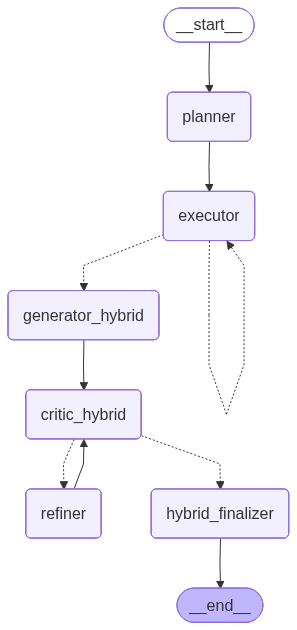

In [15]:
try:
    display(Image(hybrid_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph structure: START -> planner -> executor -> (loop back to executor or go to generator_hybrid) -> critic_hybrid -> (refiner -> critic_hybrid loop or hybrid_finalizer) -> END")

In [16]:
result = hybrid_agent.invoke({
    "input": "Research the benefits of Python programming, create a summary, and make it beginner-friendly",
    "plan": [],
    "current_step": 0,
    "results": [],
    "draft": "",
    "critique": "",
    "reflection_iterations": 0,
    "final_output": ""
})

print("=" * 70)
print("FINAL OUTPUT")
print("=" * 70)
print(result["final_output"])
print("=" * 70)
print(f"Total execution steps: {result.get('current_step', 0)}")
print(f"Total reflection iterations: {result.get('reflection_iterations', 0)}")
print("=" * 70)

PLAN CREATED
1. 1. **Conduct Research**:
2. 2. **Organize Information**:
3. 3. **Draft the Summary**:
4. 4. **Review and Edit**:
5. 5. **Finalize and Share**:

Executing step 1: 1. **Conduct Research**:
Result: Step 1 result: To conduct research effectively, follow these steps:

1. **Define Your Research Quest...

Executing step 2: 2. **Organize Information**:
Result: Step 2 result: To organize the information from the previous results, we can break down the steps in...

Executing step 3: 3. **Draft the Summary**:
Result: Step 3 result: ### Summary of Steps for Effective Research

Conducting effective research involves a...

Executing step 4: 4. **Review and Edit**:
Result: Step 4 result: ### Review and Edit of Research Steps

#### Summary of Steps for Effective Research

...

Executing step 5: 5. **Finalize and Share**:
Result: Step 5 result: ### Finalized Steps for Effective Research

Conducting effective research involves a ...

Synthesizing results into draft
Initial draft created,